In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os, os.path 
import numpy as np
import pickle
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = "../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs).astype(np.float32)
    
    outputs = None

    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs).astype(np.float32)

    # one hot city information and/or position by bins
    # parmater: Number of bins

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, x, y, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.inputs, self.outputs = x, y
        
        if transform == 'MinMax':
            # Use self.transform.inverse_transform([shape: (-1, 2)]) to scale back
            scaler = MinMaxScaler()
        elif transform == 'standard':
            scaler = StandardScaler()
        if transform:
            scaler.fit(self.inputs.reshape(-1, 2))
            scaler.fit(self.outputs.reshape(-1, 2))
            self.transform = scaler

            self.inputs = scaler.transform(self.inputs.reshape(-1, 2)).reshape(-1, 50, 2)
            self.outputs = scaler.transform(self.outputs.reshape(-1, 2)).reshape(-1, 60, 2)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
        return data

    def inverse_transform(self, x):
        # Input: x shape [batch, 50/60, 2]
        out = self.transform.inverse_transform(x.reshape(-1, 2))
        return out


# combine input and output for training
class ArgoverseCombinedDataset(Dataset):
    def __init__(self, input, output, transform=None):
        super(ArgoverseCombinedDataset, self).__init__()
        self.inputs = np.concatenate((input, output), axis=1)

        if transform == 'MinMax':
            scaler = MinMaxScaler()
        elif transform == 'Standard':
            scaler = StandardScaler()
        if transform:
            scaler.fit(self.inputs.reshape(-1, 2))
            self.transform = scaler
            self.inputs = scaler.transform(self.inputs.reshape(-1, 2)).reshape(-1, 50 + 60, 2)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = self.inputs[idx]
        return data

    def inverse_transform(self, x):
        out = self.transform.inverse_transform(x.reshape(-1, 2))
        return out

In [157]:
class carLSTM(nn.Module):
    def __init__(self, batch_size, input_size=2, output_size=2, hidden_size=50, dropout=0.5):
        super(carLSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        out, (h, c) = self.lstm(x, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        return out, (h, c)

    def init_Hidden(self, device):
        # size: (layer(1), batch(1), (hidden))
        h = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        c = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        return h, c

In [158]:
# Combine both input and output

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

EPOCHS = 10
BATCH_SIZE = 16 # batch size
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

TRANSFORM = 'MinMax'
TRANSFORM = None

city = 'palo-alto'
split = 'train'

x, y = get_city_trajectories()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = carLSTM(batch_size=BATCH_SIZE)
model.to(DEVICE)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [11]:
# 1) feed in input learning step with input loss

train_dataset  = ArgoverseDataset(x_train, y_train, transform=None, combined=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_dataset = ArgoverseDataset(x_test, y_test, transform=None, combined=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)

def train_step(model, loss_fn, optimizer, dataset, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []

    for e in tqdm(range(epochs)):
        # Train
        for i, (x, y) in enumerate(train_loader):
            train_loss = 0
            model.train()
            h, c = model.init_Hidden(DEVICE)
            x = x.to(DEVICE)

            for l in range(1, x.shape[1]):
                out, (h, c) = model(x[:, l-1, :].unsqueeze(1), (h, c))
                train_loss += loss_fn(out, x[:, l, :].unsqueeze(1))

            opt.zero_grad()
            train_loss.backward()
            opt.step()

            train_losses.append(train_loss.cpu().detach())

            if i % 100 == 0:
                print(f'Batch {i} Input loss:', train_loss, end='\r')

        # Get validation loss
        model.eval()
        with torch.no_grad():
            for i, x in enumerate(val_loader):
                val_loss = 0
                h, c = model.init_Hidden(DEVICE)
                x = x.to(DEVICE)

                for l in range(1, x.shape[1]):
                    out, (h, c) = model(x[:, l-1, :].unsqueeze(1), (h, c))
                    val_loss += loss_fn(out, x[:, l, :].unsqueeze(1)).item()

                val_losses.append(val_loss) # loss per batch
            print(f'Val Epoch {i} Loss:', val_loss)

        # Plot
        fig, axs = plt.subplots(1, 2)

        axs[0].plot(train_losses)
        axs[0].set_title('Train Loss')
        axs[1].plot(val_losses)
        axs[1].set_title('Validation Loss')
        plt.tight_layout()
        plt.show()

    return train_losses, val_losses, model

train_losses, train_losses, model = train_step(model, loss_fn, opt, train_dataset, train_loader, val_loader, EPOCHS)


TypeError: __init__() got an unexpected keyword argument 'combined'

In [159]:
def train_step(model, opt, train_loader, train_losses):
    # Train
    for i, x in enumerate(train_loader):
        train_loss = 0
        model.train()
        h, c = model.init_Hidden(DEVICE)
        x = x.to(DEVICE)

        for l in range(1, x.shape[1]):
            out, (h, c) = model(x[:, l-1, :].unsqueeze(1), (h, c))
            train_loss += loss_fn(out, x[:, l, :].unsqueeze(1))

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        train_losses.append(train_loss.cpu().detach())
        if i % 50 == 0:
            print(f'Train Batch {i} / {len(train_loader)} loss:', train_loss, end='\r')

def eval_step(model, val_loader, val_losses):
    # Get validation loss
    model.eval()
    with torch.no_grad():
        for i, x in enumerate(val_loader):
            val_loss = 0
            h, c = model.init_Hidden(DEVICE)
            x = x.to(DEVICE)

            # pass in first 50 sequences
            for l in range(0, 50):
                out, (h, c) = model(x[:, l, :].unsqueeze(1), (h, c))

            # get loss of next 60 sequences
            for l in range(50, x.shape[1]):
                out, (h, c) = model(x[:, l-1, :].unsqueeze(1), (h, c))
                val_loss += loss_fn(out, x[:, l, :].unsqueeze(1)).item()

            val_losses.append(val_loss) # loss per batch
            if i % 50 == 0:
                print(f'Validation Batch {i} Loss:', val_loss, end='\r')

In [160]:
def get_prediction(model, x):
    model.eval()
    with torch.no_grad():
        h, c = model.init_Hidden(DEVICE)
        x = torch.Tensor(x).to(DEVICE)

        for l in range(50):
            out, (h, c) = model(x[:, l, :].unsqueeze(1), (h, c))

        pred = None
        for l in range(60):
            out, (h, c) = model(out, (h, c))
            if pred is None:
                pred = out.cpu()
            else:
                pred = torch.concat((pred, out.cpu()), axis=1)
    return pred

def get_random_sample(dataset, n=BATCH_SIZE):
    # grab random sample
    np.random.seed(0)
    randidx = np.random.randint(len(dataset), size=n)
    x = dataset[randidx]
    inp, out = x[:, :50, :], x[:, 50:, :]

    if TRANSFORM:
        inp = dataset.inverse_transform(inp).reshape(-1, 50, 2)
        out = dataset.inverse_transform(out).reshape(-1, 60, 2)
    return inp, out

def plot_epoch(model, train_losses, train_dataset, val_losses, val_dataset, epoch):
    # Plot max 4 random samples from training and validation
    n_plots = min(4, BATCH_SIZE)
    fig, axs = plt.subplots(2, 1+n_plots, figsize=(40, 20))
    # Plot train and val losses
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title('Train Loss')
    axs[1, 0].plot(val_losses)
    axs[1, 0].set_title('Validation Loss')
    
    train_x, train_y = get_random_sample(train_dataset)
    train_pred = get_prediction(model, train_x)
    if TRANSFORM:
        train_pred = train_dataset.inverse_transform(train_pred).reshape(-1, 60, 2)
    train_pred = train_pred[:n_plots, :, :]

    val_x, val_y = get_random_sample(val_dataset)
    val_pred = get_prediction(model, val_x)
    if TRANSFORM:
        val_pred = val_dataset.inverse_transform(val_pred).reshape(-1, 60, 2)
    val_pred = val_pred[:n_plots, :, :]


    for i in range(len(train_pred)):
        axs[0, i+1].scatter(train_x[i, :, 0], train_x[i, :, 1], label='input', c='blue')
        axs[0, i+1].scatter(train_y[i, :, 0], train_y[i, :, 1], label='output', c='orange')
        axs[0, i+1].scatter(train_pred[i, :, 0], train_pred[i, :, 1], label='prediction', c='green')
        axs[0, i+1].set_title('Random Training Example')
        axs[0, i+1].legend()
    
    for i in range(len(val_pred)):
        axs[1, i+1].scatter(val_x[i, :, 0], val_x[i, :, 1], label='input', c='blue')
        axs[1, i+1].scatter(val_y[i, :, 0], val_y[i, :, 1], label='output', c='orange')
        axs[1, i+1].scatter(val_pred[i, :, 0], val_pred[i, :, 1], label='prediction', c='green')
        axs[0, i+1].set_title('Random Validation Example')
        axs[1, i+1].legend()
    
    fig.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

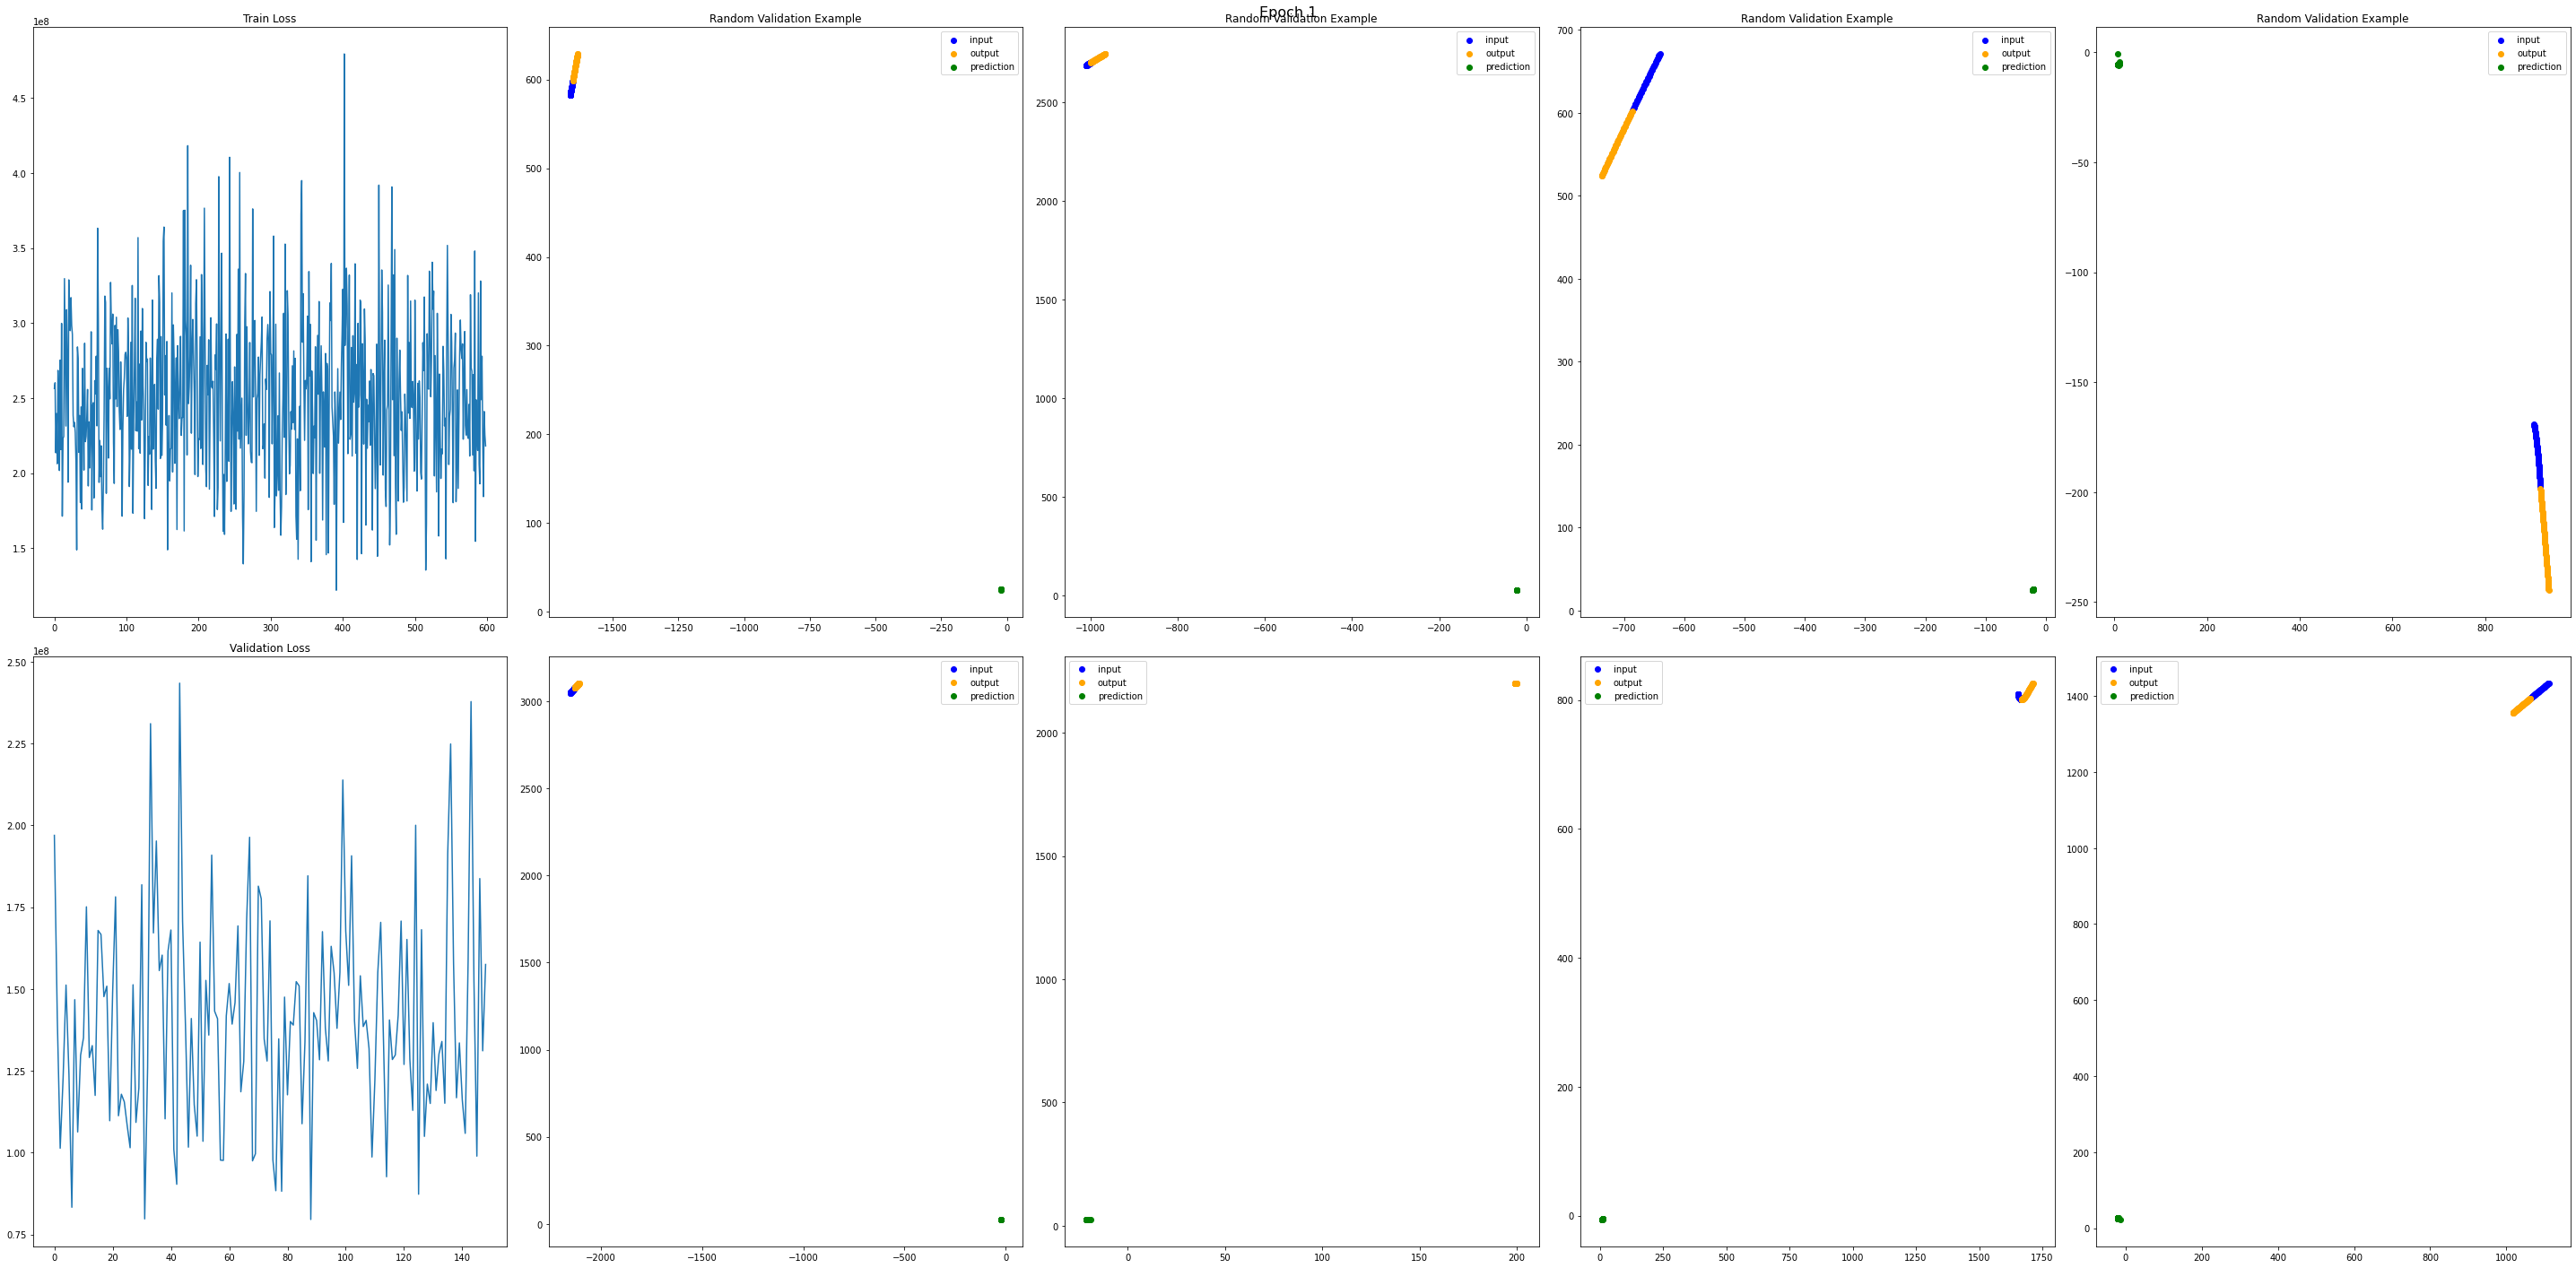

 10%|█         | 1/10 [00:41<06:09, 41.06s/it]

In [161]:
# 2) input + output
train_dataset  = ArgoverseCombinedDataset(x_train, y_train, transform=TRANSFORM)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
val_dataset = ArgoverseCombinedDataset(x_test, y_test, transform=TRANSFORM)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True)


def train(model, loss_fn, optimizer, dataset, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []

    for e in tqdm(range(1, 1 + epochs)):
        train_step(model, optimizer, train_loader, train_losses)
        eval_step(model, val_loader, val_losses)
        plot_epoch(model, train_losses, train_dataset, val_losses, val_dataset, e)

    return train_losses, val_losses, model

# 27 min 18.5s, 163.41s/epoch
train_losses, val_losses, model = train(model, loss_fn, opt, train_dataset, train_loader, val_loader, EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Val Epoch 598 Loss: 0.023496544101362815vice='cuda:0', grad_fn=<AddBackward0>)


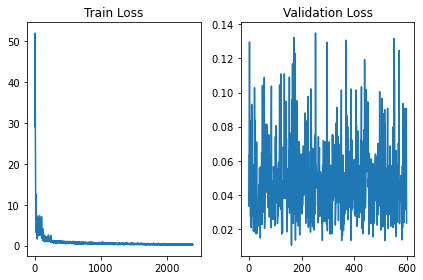

 10%|█         | 1/10 [02:43<24:30, 163.41s/it]

Val Epoch 598 Loss: 0.013225753971255472vice='cuda:0', grad_fn=<AddBackward0>)


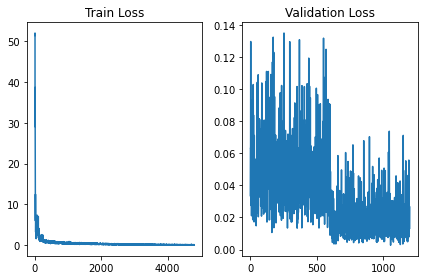

 20%|██        | 2/10 [05:27<21:49, 163.73s/it]

Val Epoch 598 Loss: 0.005111779068101896vice='cuda:0', grad_fn=<AddBackward0>)


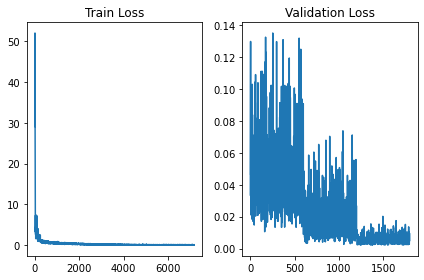

 30%|███       | 3/10 [08:10<19:05, 163.61s/it]

Val Epoch 598 Loss: 0.0013009413760300959ice='cuda:0', grad_fn=<AddBackward0>)


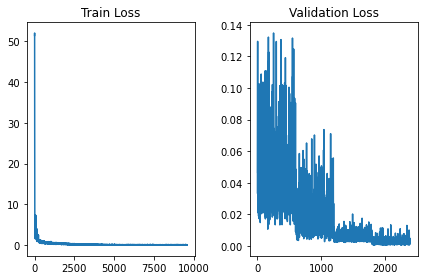

 40%|████      | 4/10 [10:54<16:20, 163.50s/it]

Val Epoch 598 Loss: 0.0017561008826305624ice='cuda:0', grad_fn=<AddBackward0>)


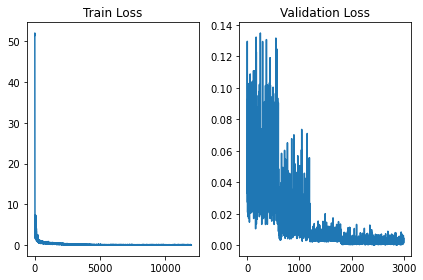

 50%|█████     | 5/10 [13:37<13:37, 163.48s/it]

Val Epoch 598 Loss: 0.0007490465991395467ice='cuda:0', grad_fn=<AddBackward0>)


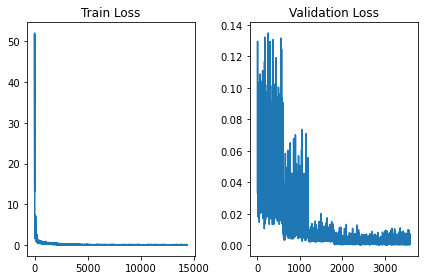

 60%|██████    | 6/10 [16:21<10:53, 163.48s/it]

Val Epoch 598 Loss: 0.0010832428342837375ice='cuda:0', grad_fn=<AddBackward0>)


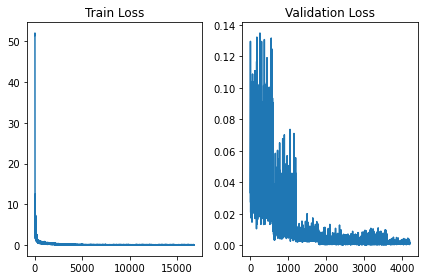

 70%|███████   | 7/10 [19:05<08:11, 163.68s/it]

Val Epoch 598 Loss: 0.0016455634568046662ice='cuda:0', grad_fn=<AddBackward0>)


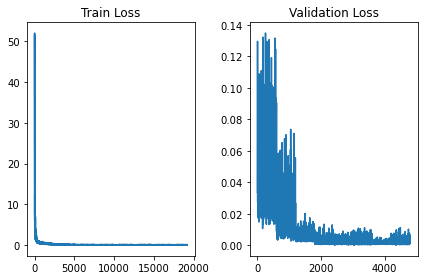

 80%|████████  | 8/10 [21:49<05:27, 163.92s/it]

Val Epoch 598 Loss: 0.001101362511235493vice='cuda:0', grad_fn=<AddBackward0>)


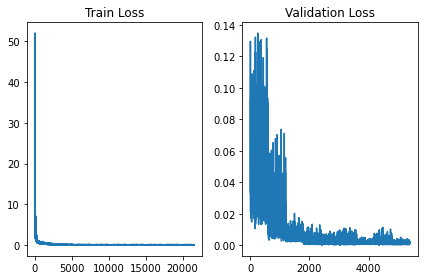

 90%|█████████ | 9/10 [24:33<02:44, 164.05s/it]

Val Epoch 598 Loss: 0.0010646080809237901ice='cuda:0', grad_fn=<AddBackward0>)


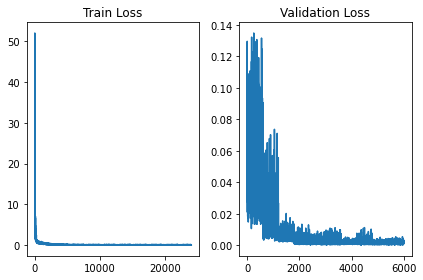

100%|██████████| 10/10 [27:18<00:00, 163.85s/it]


In [27]:
# 27 min 18.5s, 163.41s/epoch 
train_losses, val_losses, model = train_step(model, loss_fn, opt, train_dataset, train_loader, val_loader, EPOCHS)